In [22]:
# import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx

import warnings
import sys
import os
warnings.filterwarnings("ignore")
sys.stderr = open(os.devnull, 'w')

# local crs
local_crs = 32636
# path to data

## Препроцессинг данных

In [32]:
graph = nx.read_graphml('data/graph.graphml')
graph_crs = graph.graph['crs']
okrugs = gpd.read_parquet('data/model_data/okrugs.parquet')
rayons = gpd.read_parquet('data/model_data/rayons.parquet')
territories = gpd.read_file('data/territories/shlis.geojson').to_crs(graph_crs)
towns = gpd.read_parquet('/Users/mvin/Code/PopFrame/examples/data/model_data/towns.parquet').to_crs(graph_crs)

In [33]:
from popframe.preprocessing.level_filler import LevelFiller
level_filler = LevelFiller(towns=towns)
towns = level_filler.fill_levels()
towns

geometry             name  population  \
0     POINT (543142.339 6580637.744)           Болото         111   
1     POINT (544532.929 6593228.214)   Большой Остров         116   
2     POINT (544895.402 6593052.876)              Бор         116   
3     POINT (543993.111 6589582.121)        Бороватое         114   
4     POINT (538540.110 6576793.684)           Бочево         108   
...                              ...              ...         ...   
2926  POINT (399059.742 6560341.471)     Апраксин Бор          96   
2927  POINT (403967.171 6562087.081)    Александровка          98   
2928  POINT (413116.740 6573793.279)    Большая Горка         100   
2929  POINT (412458.032 6574811.307)         Дроздово         101   
2930  POINT (412158.909 6574630.200)  Большая Кунесть         101   

                         level  
0     Малое сельское поселение  
1     Малое сельское поселение  
2     Малое сельское поселение  
3     Малое сельское поселение  
4     Малое сельское поселение  
...                        ...  
2926  Малое сельское поселение  
2927  Малое сельское поселение  
2928  Малое сельское поселение  
2929  Малое сельское поселение  
2930  Малое сельское поселение  

[2931 rows x 4 columns]

In [24]:
from popframe.preprocessing.adjacency_calculator import AdjacencyCalculator

try:
  adj_mx = pd.read_pickle('data/adj_mx.pkl')
except:
  from popframe.preprocessing.adjacency_calculator import AdjacencyCalculator
  blocks = towns.copy()
  blocks.geometry = blocks.geometry.buffer(0.01)
  ac = AdjacencyCalculator(blocks=blocks, graph=graph)
  adj_mx = ac.get_dataframe()

## Создание модели


In [35]:
territories = gpd.read_file('data/territories/shlis.geojson').to_crs(graph_crs)
territories['name'].fillna('', inplace=True)

In [36]:
from popframe.models.region import Region

region = Region(
  towns=towns,
  settlements=okrugs, 
  districts=rayons, 
  accessibility_matrix=adj_mx,
  territories=territories
)

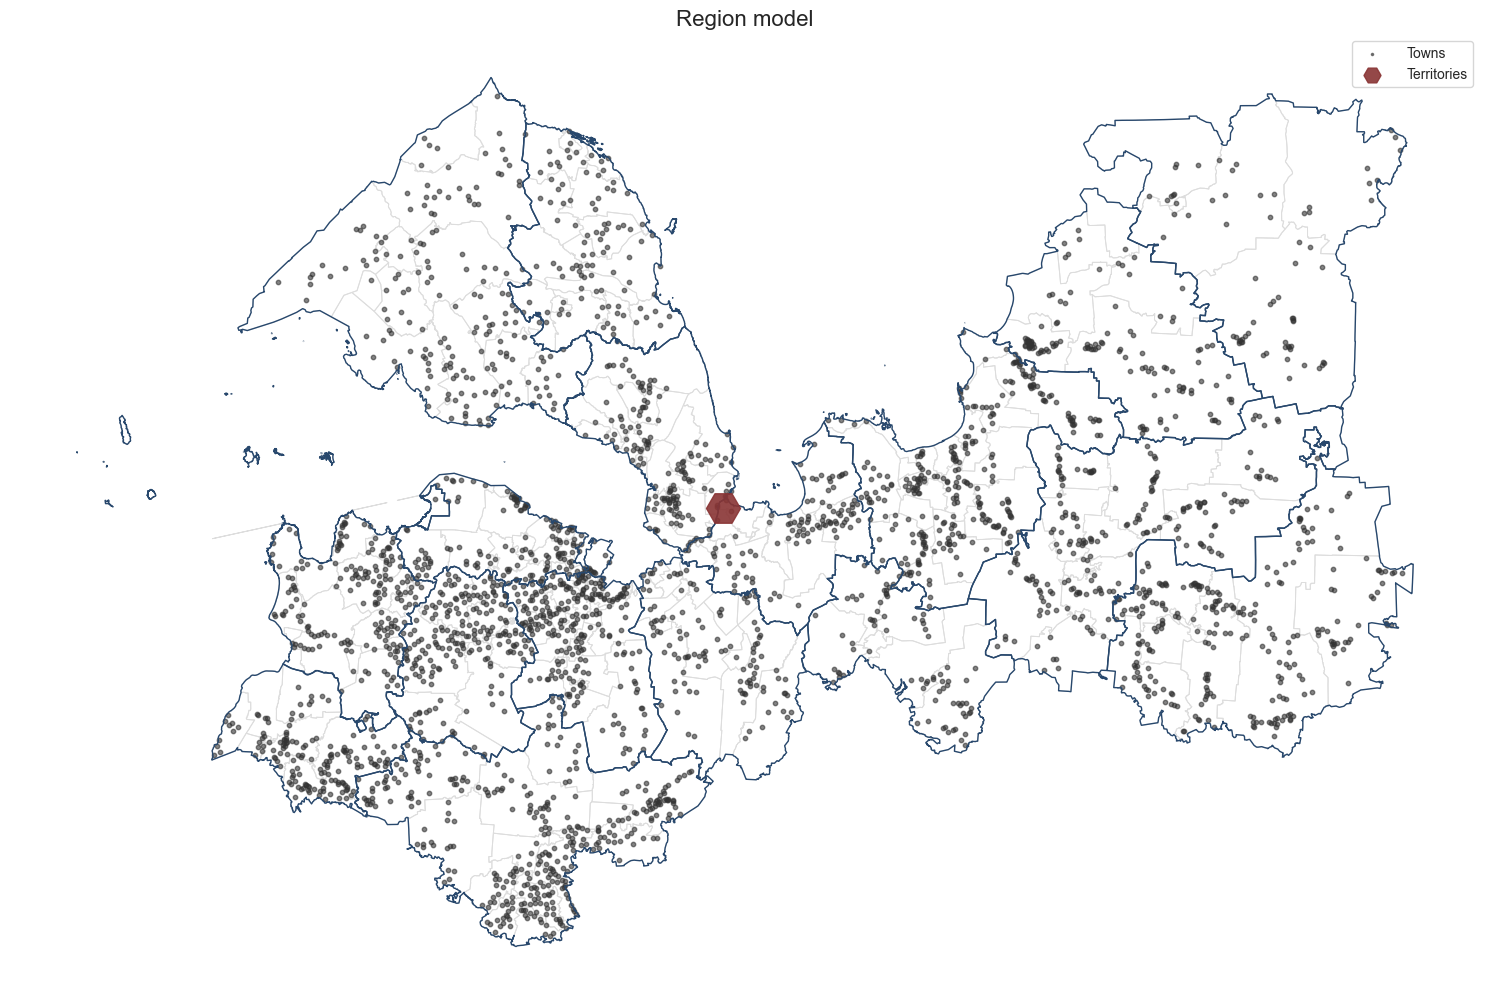

In [37]:
region.plot()

In [14]:
region.get_towns_gdf()

id             name  population                     level  \
0        0           Болото         111  Малое сельское поселение   
1        1   Большой Остров         116  Малое сельское поселение   
2        2              Бор         116  Малое сельское поселение   
3        3        Бороватое         114  Малое сельское поселение   
4        4           Бочево         108  Малое сельское поселение   
...    ...              ...         ...                       ...   
2926  2926     Апраксин Бор          96  Малое сельское поселение   
2927  2927    Александровка          98  Малое сельское поселение   
2928  2928    Большая Горка         100  Малое сельское поселение   
2929  2929         Дроздово         101  Малое сельское поселение   
2930  2930  Большая Кунесть         101  Малое сельское поселение   

                            geometry                     settlement_name  \
0     POINT (543142.339 6580637.744)          Борское сельское поселение   
1     POINT (544532.929 6593228.214)          Борское сельское поселение   
2     POINT (544895.402 6593052.876)          Борское сельское поселение   
3     POINT (543993.111 6589582.121)          Борское сельское поселение   
4     POINT (538540.110 6576793.684)          Борское сельское поселение   
...                              ...                                 ...   
2926  POINT (399059.742 6560341.471)  Трубникоборское сельское поселение   
2927  POINT (403967.171 6562087.081)  Трубникоборское сельское поселение   
2928  POINT (413116.740 6573793.279)  Трубникоборское сельское поселение   
2929  POINT (412458.032 6574811.307)  Трубникоборское сельское поселение   
2930  POINT (412158.909 6574630.200)  Трубникоборское сельское поселение   

                           district_name  
0     Бокситогорский муниципальный район  
1     Бокситогорский муниципальный район  
2     Бокситогорский муниципальный район  
3     Бокситогорский муниципальный район  
4     Бокситогорский муниципальный район  
...                                  ...  
2926     Тоснненский муниципальный район  
2927     Тоснненский муниципальный район  
2928     Тоснненский муниципальный район  
2929     Тоснненский муниципальный район  
2930     Тоснненский муниципальный район  

[2931 rows x 7 columns]

In [38]:
# region.to_pickle('Ленинградская область3.pickle')

## Работа с моделью - Создание каркаса

In [17]:
from popframe.method.popuation_frame import PopFrame
from popframe.models.region import Region

In [29]:
# Создание экземпляра GraphMethod с данными
region_model = Region.from_pickle('/Users/mvin/Code/PopFrame/examples/data/data_models/Ленинградская область.pickle')
frame_method = PopFrame(region=region_model)

# Получение графа
G = frame_method.build_network_frame()


In [30]:
num_edges = G.number_of_edges()
print("Количество рёбер в графе:", num_edges)


Количество рёбер в графе: 2930


In [ ]:
# G.nodes(data=True)

In [ ]:
# G.edges(data=True)

In [20]:
gdf_frame = frame_method.save_graph_to_geojson(G, None)
gdf_frame

geometry            name  \
0                             POINT (33.75892 59.36227)          Болото   
1                             POINT (33.78600 59.47518)  Большой Остров   
2                             POINT (33.79236 59.47356)             Бор   
3                             POINT (33.77572 59.44249)       Бороватое   
4                             POINT (33.67728 59.32820)          Бочево   
...                                                 ...             ...   
5856  LINESTRING (30.60534 59.49722, 30.58271 59.48439)             NaN   
5857  LINESTRING (30.52914 59.66430, 30.54176 59.63431)             NaN   
5858  LINESTRING (30.52914 59.66430, 30.50370 59.63608)             NaN   
5859  LINESTRING (30.52914 59.66430, 30.50283 59.68264)             NaN   
5860  LINESTRING (30.52914 59.66430, 30.54457 59.69124)             NaN   

                           level  population  
0       Малое сельское поселение       111.0  
1       Малое сельское поселение       116.0  
2       Малое сельское поселение       116.0  
3       Малое сельское поселение       114.0  
4       Малое сельское поселение       108.0  
...                          ...         ...  
5856    Малое сельское поселение         NaN  
5857  Среднее сельское поселение         NaN  
5858  Среднее сельское поселение         NaN  
5859  Среднее сельское поселение         NaN  
5860  Крупное сельское поселение         NaN  

[5861 rows x 4 columns]

In [18]:
# gdf_frame = frame_method.save_graph_to_geojson(G, 'karkas_graph_Moscow_obl.geojson')
# gdf_frame

Graph successfully saved to karkas_graph_Moscow_obl.geojson with all node attributes.


In [31]:
frame_method.get_graph_html(G, 'final_graph_with_legend.html')

### Кракас населения - версия 2

In [ ]:
from popframe.method.popuation_frame import PopFrame
from popframe.models.region import Region
region_model = Region.from_pickle('/Users/mvin/Code/PopFrame/examples/data/data_models/Москва.pickle')

In [ ]:
visualizer = PopFrame(region=region_model)
output = visualizer.build_circle_frame(output_type='html')  # or 'gdf'
output

'HTML map saved as final_circle.html'

In [ ]:
from popframe.method.popuation_frame import PopFrame
visualizer = PopFrame(region=region_model)
output = visualizer.build_circle_frame(output_type='gdf')  # or 'gdf'
output

id              name  population                       level  \
0        0  Серебряные Пруды        9358                 Малый город   
1        1           Узуново        3417  Крупное сельское поселение   
2        2         Благодать          52    Малое сельское поселение   
3        3           Ступино       66463               Средний город   
4        4            Кашира       39929                 Малый город   
...    ...               ...         ...                         ...   
2860  2860         Шелгуново           9    Малое сельское поселение   
2861  2861           Мазлово           2    Малое сельское поселение   
2862  2862          Себудово           2    Малое сельское поселение   
2863  2863        Введенское         694  Среднее сельское поселение   
2864  2864      Новолотошино        1067  Большое сельское поселение   

                                               geometry     settlement_name  \
0     POLYGON ((38.73204 54.46798, 38.73199 54.46703...  Московская область   
1     POLYGON ((38.62418 54.54061, 38.62415 54.54004...  Московская область   
2     POLYGON ((38.63076 54.47175, 38.63075 54.47161...  Московская область   
3     POLYGON ((38.10304 54.88660, 38.10292 54.88407...  Московская область   
4     POLYGON ((38.17049 54.83745, 38.17040 54.83549...  Московская область   
...                                                 ...                 ...   
2860  POLYGON ((35.60876 56.37178, 35.60876 56.37173...  Московская область   
2861  POLYGON ((35.68795 56.36313, 35.68794 56.36310...  Московская область   
2862  POLYGON ((35.52223 56.37250, 35.52223 56.37247...  Московская область   
2863  POLYGON ((35.64112 56.37377, 35.64109 56.37325...  Московская область   
2864  POLYGON ((35.65710 56.24687, 35.65707 56.24623...  Московская область   

         district_name  
0     Серебряные Пруды  
1     Серебряные Пруды  
2     Серебряные Пруды  
3              Ступино  
4               Кашира  
...                ...  
2860          Лотошино  
2861          Лотошино  
2862          Лотошино  
2863          Лотошино  
2864          Лотошино  

[2865 rows x 7 columns]